In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import gc

In [4]:
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores

In [5]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('parler-hate-speech/parler_annotated_data.csv')
test = pd.read_csv('parler-hate-speech/parler_annotated_data.csv')
submission = pd.read_csv('parler-hate-speech/parler_annotated_data.csv')
train.label_mean = train.label_mean - 1
print(f"train.shape: {train.shape}")
display(train.head())
print(f"test.shape: {test.shape}")
display(test.head())
print(f"submission.shape: {submission.shape}")
display(submission.head())

train.shape: (10121, 4)


,id,text,label_mean,disputable_post
0,a113a2d777ca4211ae97a193eee44dc1,Black men are taught that a word justifies all...,2.60,True
1,bb348c5f20a84be1bc3467d32312341c,Biden and his supporters are claiming that Bid...,3.00,True
2,39df38e04a44423f93ba1d1dc79070c9,Pelosi; âOne way or another Joe Biden will b...,0.25,False
3,68dd325894274be79f73767e92e64702,Northern California Declares Independence From...,2.00,True
4,9503e349140b4bbe9e496f4c0f15f830,Whistleblower claims top DHS officials sought ...,0.50,False


test.shape: (10121, 4)


,id,text,label_mean,disputable_post
0,a113a2d777ca4211ae97a193eee44dc1,Black men are taught that a word justifies all...,3.60,True
1,bb348c5f20a84be1bc3467d32312341c,Biden and his supporters are claiming that Bid...,4.00,True
2,39df38e04a44423f93ba1d1dc79070c9,Pelosi; âOne way or another Joe Biden will b...,1.25,False
3,68dd325894274be79f73767e92e64702,Northern California Declares Independence From...,3.00,True
4,9503e349140b4bbe9e496f4c0f15f830,Whistleblower claims top DHS officials sought ...,1.50,False


submission.shape: (10121, 4)


,id,text,label_mean,disputable_post
0,a113a2d777ca4211ae97a193eee44dc1,Black men are taught that a word justifies all...,3.60,True
1,bb348c5f20a84be1bc3467d32312341c,Biden and his supporters are claiming that Bid...,4.00,True
2,39df38e04a44423f93ba1d1dc79070c9,Pelosi; âOne way or another Joe Biden will b...,1.25,False
3,68dd325894274be79f73767e92e64702,Northern California Declares Independence From...,3.00,True
4,9503e349140b4bbe9e496f4c0f15f830,Whistleblower claims top DHS officials sought ...,1.50,False


In [32]:
accuracy_score(train['disputable_post'],np.zeros_like(train['disputable_post'].values))

0.8893389981227151

In [8]:
# ====================================================
# CV split
# ====================================================
Fold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[['id','label_mean']])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    2024
1    2024
2    2025
3    2024
4    2024
dtype: int64

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
vectorizer = TfidfVectorizer(ngram_range=(1,8), max_df=0.9, min_df=2 )
X = vectorizer.fit_transform(train.text)
X.shape

(10121, 78432)

In [10]:
svd = TruncatedSVD(n_components=128)
EMB = svd.fit_transform(X)
EMB.shape

(10121, 128)

In [11]:
fet = []
for i in range(EMB.shape[1]):
    train[f'svd{i}'] = EMB[:,i]
    fet.append(f'svd{i}')

In [12]:
train['id'] = train['id'].factorize()[0].astype('int32')

In [13]:
fet.append("id")

In [14]:
for i in range(128):
    train[f'svd_mean{i}'] = train.groupby('id')[f'svd{i}'].transform('mean')
    train[f'svd_dif{i}'] = train[f'svd_mean{i}'] - train[f'svd{i}']
    fet.append(f'svd_mean{i}')
    fet.append(f'svd_dif{i}')

In [20]:
pred.shape

(2024,)

In [23]:
train['pred'] = 0
TEST = []
NFOLDS = 5
for fold in range(NFOLDS):
    tra = train.loc[(train.fold!=fold)].reset_index(drop=True)
    val = train.loc[(train.fold==fold)].reset_index(drop=True)
    model = LGBMRegressor(learning_rate=0.1,n_estimators =1000,boosting_type = 'dart',reg_lambda = 0.5)
    model.fit(tra[fet].values, tra['label_mean'].values,eval_set=(val[fet].values, val['label_mean'].values),verbose=100,early_stopping_rounds=20)
    pred = model.predict(val[fet].values)
    print(get_score(val['label_mean'].values.reshape(-1,1),pred.reshape(-1,1)))
    gc.collect()
    break

/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaor/.local/lib/python3.7/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's l2: 1.17
[200]	valid_0's l2: 1.10988
[300]	valid_0's l2: 1.08411
[400]	valid_0's l2: 1.06536
[500]	valid_0's l2: 1.06124
[600]	valid_0's l2: 1.05898
[700]	valid_0's l2: 1.04929
[800]	valid_0's l2: 1.05522
[900]	valid_0's l2: 1.05676
[1000]	valid_0's l2: 1.05947
(1.0293036047725346, [1.0293036047725346])


In [105]:
train['pred'] = 0
TEST = []
NFOLDS = 5
for fold in range(NFOLDS):
    w = np.array([np.count_nonzero(tra['label_mean'].values.round().astype(int) == row) for row in range(5)])
    w = 1/w
    w/=w.sum()
    class_weight = {0:w[0],1:w[1],2:w[2],4:w[3],4:w[4]}
    print(class_weight)
    tra = train.loc[(train.fold!=fold)].reset_index(drop=True)
    val = train.loc[(train.fold==fold)].reset_index(drop=True)
    model = LGBMClassifier(learning_rate=0.1,n_estimators =300,reg_lambda = 0.5,class_weight = class_weight)
    model.fit(tra[fet].values, tra['label_mean'].values.round().astype(int),eval_set=(val[fet].values, val['label_mean'].values.round().astype(int)),verbose=100,early_stopping_rounds=20)
    pred = model.predict(val[fet].values)
    pred_proba = model.predict_proba(val[fet].values)
    acc = accuracy_score(val['label_mean'].values.round().astype(int),pred)
    print(acc)
    gc.collect()
    break

{0: 0.1136862883979141, 1: 0.1525533955425001, 2: 0.12873903240526285, 4: 0.3928969526707786}
[100]	valid_0's multi_logloss: 1.48251
0.3565217391304348


In [111]:
accuracy_score(val['label_mean'].values.round().astype(int)>2,pred>2)

0.6604743083003952

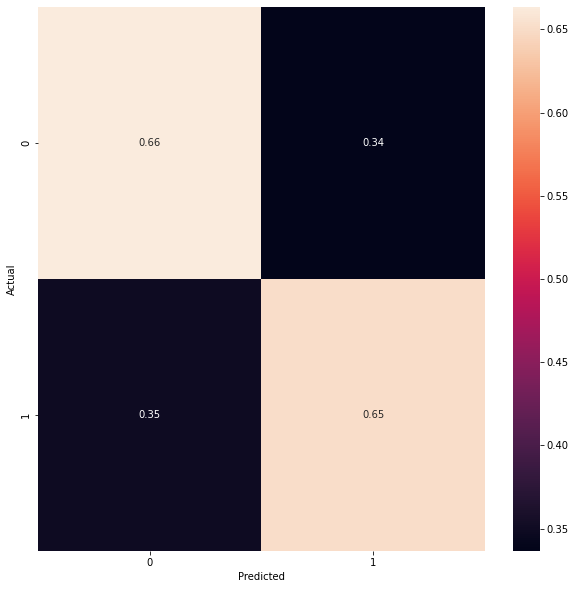

In [110]:
cm = confusion_matrix(val['label_mean'].values.round().astype(int)>2,pred>2)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)